# FastPitch + GST


## Dependencies & Includes

In [ ]:
!pip install librosa praat-parselmouth torch-optimizer tensorboardX Unidecode inflect wget tqdm scikit-learn

In [56]:
%load_ext autoreload

import os
import sys
import argparse
import numpy as np
import re
import wget
import time
import shutil
import tqdm
from collections import defaultdict

from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from torch_optimizer import Lamb
from torch.optim import Adam

import librosa
import soundfile as sf
import parselmouth
from scipy.io import wavfile
import IPython.display as ipd

# local imports
from hparams import HParamsFastpitch
from nv_extern.tacotron2.arg_parser import parse_tacotron2_args
from nv_extern.tacotron2.model import Tacotron2
from nv_extern.waveglow.model import WaveGlow
from nv_extern.waveglow.denoiser import Denoiser
from nv_extern.common.text.symbols import get_symbols
from nv_extern.common.text.text_processing import TextProcessing

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
assert torch.cuda.is_available(), "Need some GPU to train the model"
device = torch.device("cuda")
print("GPU found: {}".format(torch.cuda.get_device_name(device)))

GPU found: NVIDIA GeForce GTX 1080 Ti


In [3]:
ljspeech_data_path = "LJSpeech-1.1"
prepr_data_path = "LJSpeech_prepr"

train_filelist_path = "filelists/train_filelist.txt"
val_filelist_path = "filelists/val_filelist.txt"


logs_dir = "logs_dir"
gst_logs_dir = "gst_logs_dir"

pretrained_models_path = "pretrained_models"

if not os.path.exists(pretrained_models_path):
    os.mkdir(pretrained_models_path)

synth_wavs_path = "synth_wavs"

In [4]:
_prev_bytes = 0


def bar_progress(current, total, width=80):
    global _prev_bytes

    pq = _prev_bytes / total
    cq = current / total
    if _prev_bytes > current or (cq - pq) * 1000 > 1:
        _prev_bytes = current
    else:
        return
    progress_message = "Downloading: %d%% [%d / %d] bytes" % (cq * 100, current, total)
    # Don't use print() as it will print in new line every time.
    sys.stdout.write("\r" + progress_message)
    sys.stdout.flush()


def getfile(url, dest):
    wget.download(url, dest, bar=bar_progress)

In [5]:
hparams = HParamsFastpitch({"batch_size": 32})

Parameters redefinitions:
batch_size = 32


In [6]:
def load_from_checkpoint(model, state_dict):
    if not hasattr(model, "module"):
        state_dict = {
            name.replace("module.", ""): param for name, param in state_dict.items()
        }
    else:
        for key, value in state_dict.items():
            break
        if key[:6] != "module":
            state_dict = {"module." + name: param for name, param in state_dict.items()}

    model.load_state_dict(state_dict)

## Download data

In [7]:
ljs_arch = "LJSpeech-1.1.tar.bz2"
taco2_url = "http://data.keithito.com/data/speech/" + ljs_arch

In [8]:
getfile(taco2_url, ljs_arch)

Downloading: 99% [2747006976 / 2748572632] bytes

In [9]:
!tar -xf {ljs_arch}

## Mel, duration and pitch extraction

### Text

In [8]:
os.mkdir(prepr_data_path)

FileExistsError: [Errno 17] File exists: 'LJSpeech_prepr'

In [10]:
def parse_filelist(fname):
    data = []
    with open(fname) as ifile:
        for l in ifile:
            fid, _, text = l.strip().split("|")
            data.append((fid, text))
    return data

In [11]:
fl = parse_filelist(os.path.join(ljspeech_data_path, "metadata.csv"))

tp = TextProcessing("english_basic", ["english_cleaners"])

In [14]:
for file_id, text in tqdm.tqdm(fl):
    text_encoded = np.array(tp.encode_text(text))
    text_path = os.path.join(prepr_data_path, file_id + ".text.npy")
    np.save(text_path, text_encoded)

100%|██████████| 13100/13100 [00:10<00:00, 1255.82it/s]


### Mel

In [12]:
mel_basis = librosa.filters.mel(
    sr=hparams.sample_rate,
    n_fft=hparams.n_fft,
    n_mels=hparams.n_mel_channels,
    fmin=hparams.min_frequency,
    fmax=hparams.max_frequency,
)


def mel_spectrogram(audio, hparams):
    def linear_to_mel(s):
        return np.dot(mel_basis, s)

    def amp_to_db(x):
        return np.log(np.maximum(1e-5, x))

    spectr = librosa.stft(
        audio,
        n_fft=hparams.n_fft,
        hop_length=hparams.hop_length,
        win_length=hparams.win_length,
        window=hparams.window,
    )

    spectr = np.abs(spectr)
    mel_spectr = amp_to_db(linear_to_mel(spectr))
    return mel_spectr


def get_mel(pcm_path, mel_path, hparams):
    audio, sr = sf.read(pcm_path, dtype="float32")
    audio = librosa.resample(y=audio, orig_sr=sr, target_sr=hparams.sample_rate)
    np.save(mel_path, mel_spectrogram(audio, hparams))


def extract_mels(wav_path, out_dir, hparams):
    for filename in tqdm.tqdm(os.listdir(wav_path)):
        file_id = re.search(r"(.*).wav", filename).group(1)
        mel_path = os.path.join(out_dir, file_id + ".mel")
        get_mel(os.path.join(wav_path, filename), mel_path, hparams)

In [ ]:
extract_mels(os.path.join(ljspeech_data_path, "wavs"), prepr_data_path, hparams)

### Durations extraction

In [13]:
taco2_url = "https://api.ngc.nvidia.com/v2/models/nvidia/tacotron2_pyt_ckpt_amp/versions/19.12.0/files/nvidia_tacotron2pyt_fp16.pt"
taco2_path = os.path.join(pretrained_models_path, "tacotron2")

In [24]:
getfile(taco2_url, taco2_path)

Downloading: 99% [338214912 / 338398023] bytes

In [14]:
class TacoDataset(torch.utils.data.Dataset):
    def __init__(self, directory):
        super(TacoDataset, self).__init__()
        self.directory = directory
        self.mel_paths = []
        self.text_paths = []
        self.file_ids = []

        for filename in os.listdir(directory):
            if ".text.npy" not in filename:
                continue
            file_id = re.search(r"(.*).text.npy", filename).group(1)
            self.file_ids.append(file_id)
            text_path = os.path.join(self.directory, filename)
            self.text_paths.append(text_path)
            self.mel_paths.append(text_path.replace(".text.npy", ".mel.npy"))

    def __getitem__(self, idx):
        text = torch.IntTensor(np.load(self.text_paths[idx]))
        mel = torch.FloatTensor(np.load(self.mel_paths[idx]))
        file_id = self.file_ids[idx]
        return (text, mel, file_id)

    def __len__(self):
        return len(self.text_paths)


class TacoCollate:
    def __init__(self, n_mel_channels):
        self.n_mel_channels = n_mel_channels

    def __call__(self, batch):
        batch = sorted(batch, key=lambda x: x[0].size(0), reverse=True)

        max_text_length = max([text.size(0) for text, *_ in batch])
        max_mel_length = max([mel.size(1) for _, mel, *_ in batch])

        texts_padded = torch.LongTensor(len(batch), max_text_length).zero_()
        text_lengths = torch.LongTensor(len(batch)).zero_()
        mels_padded = torch.FloatTensor(
            len(batch), self.n_mel_channels, max_mel_length
        ).zero_()
        mel_lengths = torch.LongTensor(len(batch)).zero_()

        file_ids = []

        for i, (text, mel, file_id) in enumerate(batch):
            texts_padded[i, : text.size(0)] = text
            text_lengths[i] = text.size(0)
            mels_padded[i, :, : mel.size(1)] = mel
            mel_lengths[i] = mel.size(1)
            file_ids.append(file_id)

        max_len = torch.max(text_lengths.data).item()
        return (texts_padded, text_lengths, mels_padded, max_len, mel_lengths), file_ids

In [15]:
from numba import jit, prange


@jit(nopython=True)
def dp_alignment(att_map):
    # assumes mel x text

    log_attn_map = np.log(att_map)
    width = 1

    opt = np.zeros_like(log_attn_map)
    log_attn_map = log_attn_map.copy()
    log_attn_map[0, 1:] = -np.inf
    log_p = np.zeros_like(log_attn_map)
    log_p[0, :] = log_attn_map[0, :]
    prev_ind = np.zeros_like(log_attn_map, dtype=np.int64)
    for i in range(1, log_attn_map.shape[0]):
        for j in range(log_attn_map.shape[1]):  # for each text dim
            prev_j = np.arange(max(0, j - width), j + 1)
            prev_log = np.array([log_p[i - 1, prev_idx] for prev_idx in prev_j])

            ind = np.argmax(prev_log)
            log_p[i, j] = log_attn_map[i, j] + prev_log[ind]
            prev_ind[i, j] = prev_j[ind]

    # now backtrack
    curr_text_idx = log_attn_map.shape[1] - 1
    for i in range(log_attn_map.shape[0] - 1, -1, -1):
        opt[i, curr_text_idx] = 1
        curr_text_idx = prev_ind[i, curr_text_idx]
    opt[0, curr_text_idx] = 1
    return opt.sum(axis=0)

In [16]:
def extract_durations(taco_checkpoint_path, data_path, hparams, batch_size=8):
    taco_checkpoint = torch.load(taco_checkpoint_path)
    taco_model = Tacotron2(**taco_checkpoint["config"]).to(device)
    load_from_checkpoint(taco_model, taco_checkpoint["state_dict"])
    taco_model.eval()

    taco_dataset = TacoDataset(data_path)
    taco_collate = TacoCollate(hparams.n_mel_channels)
    taco_dataloader = DataLoader(
        taco_dataset, batch_size=batch_size, collate_fn=taco_collate
    )

    for batch, file_ids in tqdm.tqdm(taco_dataloader):
        with torch.no_grad():
            batch = [
                elem.to(device) if torch.is_tensor(elem) else elem for elem in batch
            ]
            _, text_lengths, _, _, mel_lengths = batch

            *_, alignments = taco_model.forward(batch)
            alignments = alignments.cpu().numpy()

            for j, ali in enumerate(alignments):
                dur_path = os.path.join(data_path, file_ids[j] + ".dur")

                ali = ali[: mel_lengths[j], : text_lengths[j]]
                durations = dp_alignment(ali)
                np.save(dur_path, durations)
                # return durations

In [75]:
dur = extract_durations(taco2_path, prepr_data_path, hparams, batch_size=32)

100%|██████████| 410/410 [06:21<00:00,  1.07it/s]


In [76]:
cnt = 0
sum = 0
for i, _ in tqdm.tqdm(fl):
    text = np.load(os.path.join(prepr_data_path, i + ".text.npy"))
    dur = np.load(os.path.join(prepr_data_path, i + ".dur.npy"))
    for c, d in zip(text, dur):
        if c == 38:
            cnt += 1
            sum += d
mean_a_duration = sum / cnt
print("Mean 'a' duration in the corpus is {} frames".format(mean_a_duration))
assert np.abs(mean_a_duration - 6.7823) < 0.01

100%|██████████| 13100/13100 [00:06<00:00, 1889.07it/s]

Mean 'a' duration in the corpus is 6.776461853060032 frames


### Pitch extraction


In [17]:
def maybe_pad(vec, l):
    assert np.abs(vec.shape[0] - l) <= 3
    vec = vec[:l]
    if vec.shape[0] < l:
        vec = np.pad(vec, pad_width=(0, l - vec.shape[0]))
    return vec

In [18]:
def calculate_pitch(wav_path, durs):
    durs = durs.astype(int)
    mel_len = durs.sum().astype(int)
    durs_cum = np.cumsum(np.pad(durs, (1, 0))).astype(int)

    snd = parselmouth.Sound(wav_path)
    pitch = snd.to_pitch(time_step=snd.duration / (mel_len + 3)).selected_array[
        "frequency"
    ]
    assert np.abs(mel_len - pitch.shape[0]) <= 1.0

    # Average pitch over characters
    pitch_char = np.zeros((durs.shape[0],), dtype=float)
    for idx, a, b in zip(range(int(mel_len)), durs_cum[:-1], durs_cum[1:]):
        values = pitch[a:b][np.where(pitch[a:b] != 0.0)[0]]
        pitch_char[idx] = np.mean(values) if len(values) > 0 else 0.0

    pitch_char = maybe_pad(pitch_char, len(durs))

    return pitch_char

In [19]:
def extract_pitch(wavs_path, preproc_data_path):
    for filename in tqdm.tqdm(os.listdir(wavs_path)):
        file_id = re.search(r"(.*).wav", filename).group(1)
        wav_path = os.path.join(wavs_path, filename)
        dur_path = os.path.join(preproc_data_path, file_id + ".dur.npy")
        pitch_path = os.path.join(preproc_data_path, file_id + ".pt.npy")

        dur = np.load(dur_path)
        pitch = calculate_pitch(str(wav_path), dur)
        np.save(pitch_path, pitch)

In [80]:
extract_pitch(os.path.join(ljspeech_data_path, "wavs"), prepr_data_path)

100%|██████████| 13100/13100 [03:17<00:00, 66.20it/s]


## Data utils

Some helper classes for training

In [20]:
LJSPEECH_MEAN = 218.44949768191876
LJSPEECH_STD = 64.85769765940508

In [21]:
class FastPitchDataset(torch.utils.data.Dataset):
    """
    Provides random access to the samples
    returns data in the form of (text, mel, duration, pitch)
    """

    def __init__(self, directory, filelist_path):
        super(FastPitchDataset, self).__init__()
        self.directory = directory
        self.mel_paths = []
        self.pitch_paths = []
        self.dur_paths = []
        self.text_paths = []

        with open(filelist_path, "r") as filelist:
            file_ids = filelist.readlines()
        file_ids = [elem.strip() for elem in file_ids]

        for file_id in file_ids:
            text_path = os.path.join(directory, file_id + ".text.npy")
            self.text_paths.append(text_path)
            self.pitch_paths.append(text_path.replace(".text.npy", ".pt.npy"))
            self.dur_paths.append(text_path.replace(".text.npy", ".dur.npy"))
            self.mel_paths.append(text_path.replace(".text.npy", ".mel.npy"))

    def __getitem__(self, idx):
        text = torch.IntTensor(np.load(self.text_paths[idx]))
        mel = torch.FloatTensor(np.load(self.mel_paths[idx]))
        dur = torch.FloatTensor(np.load(self.dur_paths[idx]))
        pitch = torch.FloatTensor(np.load(self.pitch_paths[idx]))

        pitch[pitch != 0] = (pitch[pitch != 0] - LJSPEECH_MEAN) / LJSPEECH_STD

        return (text, mel, dur, pitch)

    def __len__(self):
        return len(self.text_paths)


class FastPitchCollate:
    """
    Groups and pads the date to the batches,
    adds lengths of texts and mels tensors to the batch info
    """

    def __init__(self, n_mel_channels):
        self.n_mel_channels = n_mel_channels

    def __call__(self, batch):
        max_text_length = max([text.size(0) for text, *_ in batch])
        max_mel_length = max([mel.size(1) for _, mel, *_ in batch])

        texts_padded = torch.LongTensor(len(batch), max_text_length).zero_()
        text_lengths = torch.LongTensor(len(batch)).zero_()
        mels_padded = torch.FloatTensor(
            len(batch), self.n_mel_channels, max_mel_length
        ).zero_()
        mel_lengths = torch.LongTensor(len(batch)).zero_()
        dur_padded = torch.zeros_like(texts_padded, dtype=batch[0][2].dtype)
        pitch_padded = torch.zeros(
            dur_padded.size(0), dur_padded.size(1), dtype=batch[0][3].dtype
        )

        for i, (text, mel, dur, pitch) in enumerate(batch):
            texts_padded[i, : text.size(0)] = text
            text_lengths[i] = text.size(0)
            mels_padded[i, :, : mel.size(1)] = mel
            mel_lengths[i] = mel.size(1)
            dur_padded[i, : dur.shape[0]] = dur
            pitch_padded[i, : pitch.shape[0]] = pitch

        return (
            texts_padded,
            text_lengths,
            mels_padded,
            mel_lengths,
            dur_padded,
            pitch_padded,
        )

In [22]:
def batch_to_device(batch, device):
    """
    Pushes all the numeric data to GPU
    Splits input and output data of the model
    """
    (texts, text_lengths, mels, mel_lengths, dur, pitch) = [
        tensor.to(device) if tensor is not None else None for tensor in batch
    ]

    x = (texts, text_lengths, mels, mel_lengths, dur, pitch)
    y = (mels, dur, text_lengths, pitch)
    return x, y

In [23]:
def mask_from_lens(lengths, max_len=None):
    """
    With mels' or texts' lengths given creates a 0-1 mask for losses
    """
    if max_len is None:
        max_len = torch.max(lengths).item()
    ids = torch.arange(0, max_len, device=lengths.device)
    mask = ids < lengths.unsqueeze(1)
    return mask

### Loss function

In [24]:
class FastPitchLoss(nn.Module):
    def __init__(self, hparams):
        super(FastPitchLoss, self).__init__()
        self.dur_predictor_loss_scale = hparams.dur_predictor_loss_scale
        self.pitch_predictor_loss_scale = hparams.pitch_predictor_loss_scale

    def forward(self, model_out, targets, meta_agg="mean"):
        """
        Here you get
        * model_out, which is a tuple of
            mel_output, decoding_mask, predicted_duration, log_pred_duration and predicted_pitch
        * targets, which is also a tuple:
            mel_target, duration_target, duration_lengths, pitch_target

        you should compute loss - a weighted (look at constructor and hparams) sum of
            (masked) l2 mels, pitch and durations losses
        also, to draw graphs you should return the components separately - in a dict meta - kv struct with keys:
            * loss
            * mel_loss
            * duration_predictor_loss
            * pitch_loss
            * duration_l1_error
        """
        mel_out, dec_mask, dur_pred, log_dur_pred, pitch_pred = model_out
        mel_tgt, dur_tgt, dur_lens, pitch_tgt = targets
        mel_tgt.requires_grad = False
        # (B,H,T) => (B,T,H)
        mel_tgt = mel_tgt.transpose(1, 2)

        dur_mask = mask_from_lens(dur_lens, max_len=dur_tgt.size(1))

        loss_fn = F.mse_loss

        log_dur_tgt = torch.log(dur_tgt.float() + 1)
        log_dur_loss = loss_fn(log_dur_pred, log_dur_tgt, reduction="none")
        log_dur_loss = (log_dur_loss * dur_mask).sum() / dur_mask.sum()

        ldiff = mel_tgt.size(1) - mel_out.size(1)
        mel_out = F.pad(mel_out, (0, 0, 0, ldiff, 0, 0), value=0.0)
        mel_mask = mel_tgt.ne(0).float()
        loss_fn = F.mse_loss
        mel_loss = loss_fn(mel_out, mel_tgt, reduction="none")
        mel_loss = (mel_loss * mel_mask).sum() / mel_mask.sum()

        # print(pitch_tgt.size(), pitch_pred.size())
        # ldiff = pitch_tgt.size(1) - pitch_pred.size(1)
        # pitch_pred = F.pad(pitch_pred, (0, ldiff, 0, 0, 0, 0), value=0.0)
        pitch_loss = F.mse_loss(pitch_tgt, pitch_pred, reduction="none")
        # print(dur_mask.size(), pitch_loss.size())
        pitch_loss = (pitch_loss * dur_mask).sum() / dur_mask.sum()

        loss = (
            mel_loss
            + pitch_loss * self.pitch_predictor_loss_scale
            + log_dur_loss * self.dur_predictor_loss_scale
        )

        meta = {
            "loss": loss.clone().detach(),
            "mel_loss": mel_loss.clone().detach(),
            "duration_predictor_loss": log_dur_loss.clone().detach(),
            "pitch_loss": pitch_loss.clone().detach(),
            "duration_l1_error": (
                torch.abs(dur_pred - dur_tgt).sum() / dur_mask.sum()
            ).detach(),
        }

        assert meta_agg in ("sum", "mean")
        if meta_agg == "sum":
            bsz = mel_out.size(0)
            meta = {k: v * bsz for k, v in meta.items()}

        return loss, meta

### Logger

In [25]:
class FastpitchLogger:
    """
    Logger. Saves/loads model, flushes on validation, can log gradients (useful for debugging the core AM model)
    """

    def __init__(self, logdir, hparams):
        self.eval_interval = hparams.eval_interval
        self.global_checkpoint_coef = hparams.global_checkpoint_coef
        self.logdir = logdir

        self.train_logger = SummaryWriter(os.path.join(logdir, "train"))
        self.val_logger = SummaryWriter(os.path.join(logdir, "val"))

    def log_grads(self, step, model):
        norms = [p.grad.norm().item() for p in model.parameters() if p.grad is not None]
        for stat in ("max", "min", "mean"):
            self.train_logger.add_scalar(f"grad_{stat}", getattr(np, stat)(norms), step)

    def log(self, logger, step, meta):
        for k, v in meta.items():
            logger.add_scalar(k, v.item() if hasattr(v, "item") else v, step)

    def log_training(self, step, meta):
        print(f"train : {meta['step']}  loss {meta['loss']:.4f}")
        self.log(self.train_logger, step, meta)

    def log_validation(self, step, meta):
        print(f"val : {meta['step']}  loss {meta['loss']}")
        self.log(self.val_logger, step, meta)

        for w in self.train_logger.all_writers.values():
            w.flush()
        for w in self.val_logger.all_writers.values():
            w.flush()

    def step_to_path(self, step):
        return os.path.join(self.logdir, f"{step:07d}_snapshot.pth")

    @staticmethod
    def load_last_checkpoint(logdir):
        steps = [
            int(filename.replace("_snapshot.pth", ""))
            for filename in os.listdir(logdir)
            if "_snapshot.pth" in filename
        ]

        if len(steps) == 0:
            return {"step": 0, "state_dict": None}

        return torch.load(os.path.join(logdir, f"{max(steps):07d}_snapshot.pth"))

    def save_checkpoint(self, model, optimizer, step, hparams):
        checkpoint = {
            "step": step,
            "state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "params": hparams.__dict__,
        }

        torch.save(checkpoint, self.step_to_path(step))

        # remove unnecessary snapshots
        if step > self.eval_interval and (step - self.eval_interval) % (
            self.global_checkpoint_coef * self.eval_interval
        ):
            os.remove(self.step_to_path(step - self.eval_interval))

## Model

FastPitch paper https://arxiv.org/abs/2006.06873

In [26]:
class PositionalEmbedding(nn.Module):
    """
    Sin and cos positional embeddings
    """

    def __init__(self, d_model):
        super(PositionalEmbedding, self).__init__()
        self.demb = d_model
        inv_freq = 1 / (10000 ** (torch.arange(0.0, self.demb, 2.0) / self.demb))
        self.register_buffer("inv_freq", inv_freq)

    """
    * pos_seq - 1...N array
    """

    def forward(self, pos_seq):
        sinusoid_inp = torch.matmul(
            torch.unsqueeze(pos_seq, -1), torch.unsqueeze(self.inv_freq, 0)
        )
        pos_emb = torch.cat([sinusoid_inp.sin(), sinusoid_inp.cos()], dim=1)
        return pos_emb[None, :, :]

In [27]:
class PositionwiseConvFF(nn.Module):
    """
    This position-wise convolutional layer
    It is a sequence:
    * Conv1d, d_model -> d_inner
    * ReLU
    * Conv1d, d_inner -> d_model
    * Dropout
    * Residual (+input)
    * LayerNorm
    """

    def __init__(self, d_model, d_inner, kernel_size, dropout):
        super(PositionwiseConvFF, self).__init__()
        self.CoreNet = nn.Sequential(
            nn.Conv1d(d_model, d_inner, kernel_size, 1, (kernel_size // 2)),
            nn.ReLU(),
            nn.Conv1d(d_inner, d_model, kernel_size, 1, (kernel_size // 2)),
            nn.Dropout(dropout),
        )

        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inp):
        core_out = inp.transpose(1, 2)
        core_out = self.CoreNet(core_out)
        core_out = core_out.transpose(1, 2)

        # residual connection + layer normalization
        # print(inp.size(), core_out.size())
        output = self.layer_norm(inp + core_out).to(inp.dtype)
        return output

In [28]:
class FFTransformer(nn.Module):
    """
    Here, you should implement the sequence:
    * embeddings of the categorical input, if embed_input is True
    * dropout(input + embeddings), if dropemb is not 0
    * n_layers of (multi-head self-attention + dropout + layernorm + pos-wise convFF)
    * all this should be masked according to the lengths

    Parameters:
    * n_symbols - number of symbols (in case of cat input)
    * n_layer - self-att layers
    * d_model - outer dim, n_embedding for graphemes, n_mel for audio
    * n_head - number of attention heads
    * d_head - size of each head
    * kernel size - pos-wise convolution kernel size
    * dropout - DO after the self-attention
    * dropatt - DO at self-attention probs
    * dropemb - DO after the positional embeddings addition
    * embed_input - if true, input is treated as categorical and additional nn.Embeddings should be added
    * pad_idx - only for embed_input = true: special value categorical input are padded with

    """

    def __init__(
        self,
        n_symbols,
        n_layer,
        n_head,
        d_model,
        d_head,
        d_inner,
        kernel_size,
        dropout,
        dropatt,
        dropemb=0.0,
        embed_input=True,
        pad_idx=0,
    ):
        super(FFTransformer, self).__init__()

        self.d_model = d_model
        self.n_head = n_head
        self.d_head = d_head
        self.padding_idx = pad_idx

        if embed_input:
            self.word_emb = nn.Embedding(
                n_symbols, d_model, padding_idx=self.padding_idx
            )
        else:
            self.word_emb = None

        self.pos_emb = PositionalEmbedding(self.d_model)
        self.drop = nn.Dropout(dropemb)
        self.layers = nn.ModuleList()

        for _ in range(n_layer):
            self.layers.append(
                TransformerLayer(
                    n_head,
                    d_model,
                    d_head,
                    d_inner,
                    kernel_size,
                    dropout,
                    dropatt=dropatt,
                )
            )

    def forward(self, dec_inp, mel_lens=None):
        """
        * dec_inp - input, continuous or categorical
        * mel_lens - for embed_input = False: lengths of input, need for padding
        Return:
        * tuple: processed output and padding bitmask
        """
        if self.word_emb is None:
            inp = dec_inp
            mask = mask_from_lens(mel_lens).unsqueeze(2)
        else:
            inp = self.word_emb(dec_inp)
            mask = (dec_inp != self.padding_idx).unsqueeze(2)

        #  print(inp.size(), mel_lens)
        pos_seq = torch.arange(inp.size(1), device=inp.device, dtype=inp.dtype)
        # print(self.pos_emb(pos_seq).size(), mask.size())
        pos_emb = self.pos_emb(pos_seq) * mask

        out = self.drop(inp + pos_emb)

        for layer in self.layers:
            out = layer(out, mask=mask)

        return out, mask


class TransformerLayer(nn.Module):
    def __init__(
        self, n_head, d_model, d_head, d_inner, kernel_size, dropout, **kwargs
    ):
        super(TransformerLayer, self).__init__()

        self.dec_attn = MultiHeadAttn(n_head, d_model, d_head, dropout, **kwargs)
        self.pos_ff = PositionwiseConvFF(d_model, d_inner, kernel_size, dropout)

    def forward(self, dec_inp, mask=None):
        output = self.dec_attn(dec_inp, attn_mask=~mask.squeeze(2))
        output *= mask
        output = self.pos_ff(output)
        output *= mask
        return output


class MultiHeadAttn(nn.Module):
    def __init__(self, n_head, d_model, d_head, dropout, dropatt=0.1):
        super(MultiHeadAttn, self).__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_head = d_head
        self.scale = 1 / (d_head**0.5)

        self.qkv_net = nn.Linear(d_model, 3 * n_head * d_head)
        self.drop = nn.Dropout(dropout)
        self.dropatt = nn.Dropout(dropatt)
        self.o_net = nn.Linear(n_head * d_head, d_model, bias=False)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inp, attn_mask=None):
        return self._forward(inp, attn_mask)

    def _forward(self, inp, attn_mask=None):
        residual = inp

        inp = self.layer_norm(inp)

        n_head, d_head = self.n_head, self.d_head

        head_q, head_k, head_v = torch.chunk(self.qkv_net(inp), 3, dim=2)
        head_q = head_q.view(inp.size(0), inp.size(1), n_head, d_head)
        head_k = head_k.view(inp.size(0), inp.size(1), n_head, d_head)
        head_v = head_v.view(inp.size(0), inp.size(1), n_head, d_head)

        q = head_q.permute(2, 0, 1, 3).reshape(-1, inp.size(1), d_head)
        k = head_k.permute(2, 0, 1, 3).reshape(-1, inp.size(1), d_head)
        v = head_v.permute(2, 0, 1, 3).reshape(-1, inp.size(1), d_head)

        attn_score = torch.bmm(q, k.transpose(1, 2))
        attn_score.mul_(self.scale)

        if attn_mask is not None:
            attn_mask = attn_mask.unsqueeze(1).to(attn_score.dtype)
            attn_mask = attn_mask.repeat(n_head, attn_mask.size(2), 1)
            attn_score.masked_fill_(attn_mask.to(torch.bool), -float("inf"))

        attn_prob = F.softmax(attn_score, dim=2)
        attn_prob = self.dropatt(attn_prob)
        attn_vec = torch.bmm(attn_prob, v)

        attn_vec = attn_vec.view(n_head, inp.size(0), inp.size(1), d_head)
        attn_vec = (
            attn_vec.permute(1, 2, 0, 3)
            .contiguous()
            .view(inp.size(0), inp.size(1), n_head * d_head)
        )

        # linear projection
        attn_out = self.o_net(attn_vec)
        attn_out = self.drop(attn_out)

        # residual connection
        output = residual + attn_out

        output = output.to(attn_out.dtype)

        return output

## GST: style token

paper https://arxiv.org/pdf/1803.09017.pdf

In [29]:
class GST(nn.Module):
    def __init__(self, hparams):
        super(GST, self).__init__()

        self.reference_encoder = FFTransformer(
            n_symbols=None,
            n_layer=hparams.gst_n_layers,
            n_head=hparams.gst_n_heads,
            d_model=hparams.n_mel_channels,
            d_head=hparams.gst_d_head,
            d_inner=hparams.gst_conv1d_filter_size,
            kernel_size=hparams.gst_conv1d_kernel_size,
            dropout=hparams.p_gst_dropout,
            dropatt=hparams.p_gst_dropatt,
            dropemb=hparams.p_gst_dropemb,
            embed_input=False,
        )

        # additional layer to be used in GST
        self.gst_embed = nn.Parameter(
            torch.FloatTensor(hparams.style_token_count, hparams.estimator_hidden_dim)
        )
        # n_head, d_model, d_head, dropout
        self.attention = nn.MultiheadAttention(
            embed_dim=hparams.n_mel_channels,
            num_heads=hparams.stl_attention_num_heads,
            kdim=hparams.estimator_hidden_dim,
            vdim=hparams.estimator_hidden_dim,
            batch_first=True,
        )

    def forward(self, mels, mel_lengths):
        """
        Should take GT mels and return style embeddings and attention probs
        """
        # print(mels.size(), mel_lengths.size())
        N = mels.size(0)
        mels_enc, mask = self.reference_encoder(mels.permute(0, 2, 1), mel_lengths)
        # ...

        """
        mel-invariant tokens should be keys in the attention here
        and encoder output -- the query
        
        
        Please note that you should prevent unlimited growth of tokens magnitude somehow
        E.g. you can shrink them with some restrictive function:
            attention_keys = tanh(tokens_embeddings)
        """

        keys = F.tanh(self.gst_embed).unsqueeze(0).expand(N, -1, -1)
        # print(mels_enc.size(), keys.size())
        style_embed, alphas = self.attention(mels_enc, keys, keys, need_weights=True)

        return style_embed, alphas

## FastPitch
#### Temporal Predictor  (predicts a single float per each temporal location)

In [30]:
class ConvReLUNorm(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, dropout=0.0):
        super(ConvReLUNorm, self).__init__()
        self.conv = torch.nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=(kernel_size // 2),
        )
        self.norm = torch.nn.LayerNorm(out_channels)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, signal):
        out = F.relu(self.conv(signal))
        out = self.norm(out.transpose(1, 2)).transpose(1, 2)
        return self.dropout(out)


class TemporalPredictor(nn.Module):
    """
    Regressor head
    A couple of conv+reLU+layernorm blocks + projection to answer
    """

    def __init__(self, input_size, filter_size, kernel_size, dropout, n_layers=2):
        super(TemporalPredictor, self).__init__()

        self.layers = nn.Sequential(
            *[
                ConvReLUNorm(
                    input_size if i == 0 else filter_size,
                    filter_size,
                    kernel_size=kernel_size,
                    dropout=dropout,
                )
                for i in range(n_layers)
            ]
        )
        self.fc = nn.Linear(filter_size, 1, bias=True)

    def forward(self, enc_out, enc_out_mask):
        out = enc_out * enc_out_mask
        out = self.layers(out.transpose(1, 2)).transpose(1, 2)
        out = self.fc(out) * enc_out_mask
        return out.squeeze(-1)

In [31]:
def regulate_len(durations, enc_out):
    """
    Parameters:
    * durations - predicted/gt durations array
    * enc_out - encoder embeddings you need to upsample
    Returns tuple:
    * encoder upsampled states
    * frame_lengths - sums over T of durations

    """
    dtype = enc_out.dtype
    reps = durations.float()
    reps = (reps + 0.5).long()
    dec_lens = reps.sum(dim=1)

    max_len = dec_lens.max()
    reps_cumsum = torch.cumsum(F.pad(reps, (1, 0, 0, 0), value=0.0), dim=1)[:, None, :]
    reps_cumsum = reps_cumsum.to(dtype)

    range_ = torch.arange(max_len, device=enc_out.device)[None, :, None]
    mult = (reps_cumsum[:, :, :-1] <= range_) & (reps_cumsum[:, :, 1:] > range_)
    mult = mult.to(dtype)
    enc_rep = torch.matmul(mult, enc_out)

    return enc_rep, dec_lens

In [32]:
class FastPitch(nn.Module):
    def __init__(self, hparams: HParamsFastpitch):
        super(FastPitch, self).__init__()

        self.encoder = FFTransformer(
            n_symbols=hparams.n_symbols,
            n_layer=hparams.in_fft_n_layers,
            n_head=hparams.in_fft_n_heads,
            d_model=hparams.symbols_embedding_dim,
            d_head=hparams.in_fft_d_head,
            d_inner=4 * hparams.symbols_embedding_dim,
            kernel_size=hparams.in_fft_conv1d_kernel_size,
            dropout=hparams.p_in_fft_dropout,
            dropatt=hparams.p_in_fft_dropatt,
            dropemb=hparams.p_in_fft_dropemb,
            embed_input=True,
            pad_idx=hparams.pad_idx,
        )

        self.duration_predictor = TemporalPredictor(
            input_size=hparams.symbols_embedding_dim,
            filter_size=hparams.dur_predictor_filter_size,
            kernel_size=hparams.dur_predictor_kernel_size,
            dropout=hparams.p_dur_predictor_dropout,
            n_layers=hparams.dur_predictor_n_layers,
        )

        self.decoder = FFTransformer(
            n_symbols=hparams.n_symbols,
            n_layer=hparams.out_fft_n_layers,
            n_head=hparams.out_fft_n_heads,
            d_model=hparams.symbols_embedding_dim,
            d_head=hparams.out_fft_d_head,
            d_inner=4 * hparams.symbols_embedding_dim,
            kernel_size=hparams.out_fft_conv1d_kernel_size,
            dropout=hparams.p_out_fft_dropout,
            dropatt=hparams.p_out_fft_dropatt,
            dropemb=hparams.p_out_fft_dropemb,
            embed_input=False,
            pad_idx=hparams.pad_idx,
        )

        self.pitch_predictor = TemporalPredictor(
            input_size=hparams.symbols_embedding_dim,
            filter_size=hparams.pitch_predictor_filter_size,
            kernel_size=hparams.pitch_predictor_kernel_size,
            dropout=hparams.p_pitch_predictor_dropout,
            n_layers=hparams.pitch_predictor_n_layers,
        )

        self.gst = GST(hparams)
        self.pitch_emb = nn.Conv1d(
            1, hparams.symbols_embedding_dim, kernel_size=3, padding=int((3 - 1) / 2)
        )

        self.projection = nn.Linear(
            hparams.symbols_embedding_dim, hparams.n_mel_channels, bias=True
        )
        self.project_style = nn.Linear(
            hparams.n_mel_channels, hparams.symbols_embedding_dim
        )

    def forward(
        self, inputs, use_gt_durations=True, use_gt_pitch=True, max_duration=75
    ):
        """
        Inputs:
        * inputs - tuple of:
            * text - texts
            * text_lengths - lengths for padding
            * mel_tgt - targets for melspec
            * mel_lengths - for padding
            * dur_tgt - gt duration
            * pitch tgt - gt pitch
        * use_gt_durations and use_gt_pitch - True for teache-forcing (train and validation estimation)
        * max_duration - maximum possible duration
        """
        text, text_lengths, mel_tgt, mel_lengths, dur_tgt, pitch_tgt = inputs
        encoder_output, enc_mask = self.encoder(text, text_lengths)
        # print(mel_lengths)
        gst_style, alphas = self.gst(mel_tgt, mel_lengths)

        # print(gst_style.size(), alphas.size())

        gst_style_projected = (
            self.project_style(gst_style.mean(dim=1))
            .unsqueeze(1)
            .expand_as(encoder_output)
        )
        #  print(encoder_output.size(), gst_style_projected.size())
        enc_and_style = encoder_output + gst_style_projected

        pitch_pred = self.pitch_predictor(enc_and_style, enc_mask)  # .permute(0, 2, 1)
        # print(pitch_pred.size(), pitch_tgt.size())

        """
        Duration is predicted in log-scale
        """
        log_dur_pred = self.duration_predictor(enc_and_style, enc_mask)
        dur_pred = torch.clamp(torch.exp(log_dur_pred) - 1, 0, max_duration)

        if use_gt_pitch and pitch_tgt is not None:
            pitch_conv = self.pitch_emb(pitch_tgt.unsqueeze(1))
        else:
            pitch_conv = self.pitch_emb(pitch_pred.unsqueeze(1))

        pitch_conv = pitch_conv.permute(0, 2, 1)
        #  print(pitch_conv.size())

        enc_state = enc_and_style + pitch_conv

        upsampled, dec_lens = regulate_len(
            dur_tgt if use_gt_durations else dur_pred, enc_state
        )

        dec_out, dec_mask = self.decoder(upsampled, dec_lens)
        mel_out = self.projection(dec_out)

        return mel_out, dec_mask, dur_pred, log_dur_pred, pitch_pred

    def infer(self, inputs, gst_estimator):
        """
        Inputs:
        * inputs - text and texts_lengths
        * gst_estimator - nn.Module that predicts style from (encoded_text, text_lengths)
        Returns:
        * mel_output
        """
        text, text_lengths = inputs

        encoder_output, enc_mask = self.encoder(text, text_lengths)

        gst_pred = gst_estimator.forward(encoder_output, text_lengths)
        enc_and_style = encoder_output + gst_pred.unsqueeze(1)

        log_dur_pred = self.duration_predictor(enc_and_style, enc_mask)
        dur_pred = torch.clamp(torch.exp(log_dur_pred) - 1, min=0)

        pitch_pred = self.pitch_predictor(encoder_output, enc_mask)  # .permute(0, 2, 1)
        pitch_conv = self.pitch_emb(pitch_pred.unsqueeze(1)).permute(0, 2, 1)

        enc_state = enc_and_style + pitch_conv

        len_regulated, dec_lens = regulate_len(dur_pred, enc_state)

        dec_out, dec_mask = self.decoder(len_regulated, dec_lens)
        mel_out = self.projection(dec_out)

        return mel_out

# Training

In [33]:
def prepare_loaders(directory, train_filelist, val_filelist, hparams):
    train_dataset = FastPitchDataset(directory, train_filelist)
    valid_dataset = FastPitchDataset(directory, val_filelist)

    collate_fn = FastPitchCollate(hparams.n_mel_channels)

    train_loader = DataLoader(
        train_dataset,
        batch_size=hparams.batch_size,
        num_workers=4,
        shuffle=True,
        pin_memory=True,
        drop_last=True,
        collate_fn=collate_fn,
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=hparams.batch_size,
        num_workers=4,
        shuffle=False,
        pin_memory=False,
        collate_fn=collate_fn,
    )

    return train_loader, valid_loader

In [34]:
def validate(
    model,
    criterion,
    val_loader,
    device,
    use_gt_durations=False,
):
    """
    Parameters:
    * model - FastPitch
    * criterion - loss operator
    * val_loader - loader for validation data
    * device - torch GPU id
    * use_gt_durations - if use ground truth for durations
    """
    was_training = model.training
    model.eval()
    with torch.no_grad():
        val_meta = defaultdict(float)
        for i, batch in enumerate(val_loader):
            x, y = batch_to_device(batch, device)

            y_pred = model(x, use_gt_durations)

            loss, meta = criterion(y_pred, y, meta_agg="sum")
            for k, v in meta.items():
                val_meta[k] += v

        val_meta = {k: v / len(val_loader.dataset) for k, v in val_meta.items()}
        val_loss = val_meta["loss"]

    if was_training:
        model.train()
    return val_loss.item(), val_meta

In [35]:
def adjust_learning_rate(total_iter, opt, learning_rate, warmup_iters):
    """
    For training we use one-cycle learning rate schedule
    Firstly, linear growth of scale
    Then, exponential decay
    """
    if total_iter > warmup_iters:
        scale = 1.0 / (total_iter**0.5)
    else:
        scale = total_iter / (warmup_iters**1.5)

    for param_group in opt.param_groups:
        param_group["lr"] = learning_rate * scale

In [36]:
def train_fastpitch(
    dataset_dir, train_filelist_path, val_filelist_path, logdir, hparams
):
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(hparams.seed)
    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = FastPitch(hparams).to(device)
    # model = nn.DataParallel(model)
    model.train()
    torch.cuda.empty_cache()

    optimizer = Lamb(
        model.parameters(),
        lr=hparams.learning_rate,
        betas=(0.9, 0.98),
        eps=1e-9,
        weight_decay=hparams.weight_decay,
    )

    logger = FastpitchLogger(logdir, hparams)
    train_loader, valid_loader = prepare_loaders(
        dataset_dir, train_filelist_path, val_filelist_path, hparams
    )
    criterion = FastPitchLoss(hparams)

    checkpoint = FastpitchLogger.load_last_checkpoint(logdir)
    step = checkpoint["step"] or 0
    if checkpoint["state_dict"]:
        load_from_checkpoint(model, checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = step // len(train_loader)

    while True:
        if hasattr(train_loader.sampler, "set_epoch"):
            train_loader.sampler.set_epoch(epoch)
        if hasattr(train_loader.batch_sampler, "set_epoch"):
            train_loader.batch_sampler.set_epoch(epoch)

        for batch in train_loader:
            x, y = batch_to_device(batch, device)

            adjust_learning_rate(
                step, optimizer, hparams.learning_rate, hparams.warmup_steps
            )
            y_pred = model(x)

            optimizer.zero_grad()

            model.zero_grad()
            loss, meta = criterion(y_pred, y)
            loss.backward()

            logger.log_grads(step, model)

            optimizer.step()

            step += 1

            meta["step"] = step
            meta["lr"] = optimizer.param_groups[0]["lr"]
            logger.log_training(step, meta)

            if step % hparams.eval_interval == 0:
                loss, meta = validate(
                    model, criterion, valid_loader, device, use_gt_durations=True
                )

                meta["step"] = step
                logger.log_validation(step, meta)
                logger.save_checkpoint(model, optimizer, step, hparams)

            if step >= hparams.num_steps:
                return

        epoch += 1

In [ ]:
train_fastpitch(
    prepr_data_path, train_filelist_path, val_filelist_path, logs_dir, hparams
)

# GST Space

Here you should visualize the latent GST space

In [66]:
train_loader, valid_loader = prepare_loaders(
    prepr_data_path, train_filelist_path, val_filelist_path, hparams
)
torch.cuda.empty_cache()

In [68]:
logger = FastpitchLogger(logs_dir, hparams)
model = FastPitch(hparams).to(device)
checkpoint = FastpitchLogger.load_last_checkpoint(logs_dir)
if checkpoint["state_dict"]:
    load_from_checkpoint(model, checkpoint["state_dict"])

model.eval()

FastPitch(
  (encoder): FFTransformer(
    (word_emb): Embedding(69, 384, padding_idx=0)
    (pos_emb): PositionalEmbedding()
    (drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x TransformerLayer(
        (dec_attn): MultiHeadAttn(
          (qkv_net): Linear(in_features=384, out_features=192, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
          (dropatt): Dropout(p=0.1, inplace=False)
          (o_net): Linear(in_features=64, out_features=384, bias=False)
          (layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        )
        (pos_ff): PositionwiseConvFF(
          (CoreNet): Sequential(
            (0): Conv1d(384, 1536, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): ReLU()
            (2): Conv1d(1536, 384, kernel_size=(3,), stride=(1,), padding=(1,))
            (3): Dropout(p=0.1, inplace=False)
          )
          (layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        )
 

100%|██████████| 12500/12500 [01:58<00:00, 105.74it/s]


"\nVisualize space and try to listen to examples of some clusters you've noticed in the map\n"

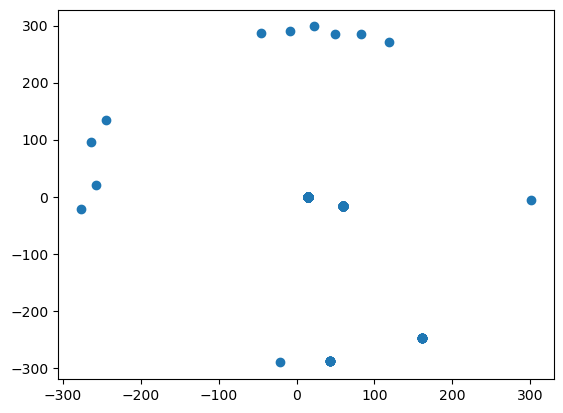

In [69]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

train_dataset = FastPitchDataset(prepr_data_path, train_filelist_path)

with torch.no_grad():
    GSTStyles = []
    for elem in tqdm.tqdm(train_dataset):
        text, mel, dur, pitch = elem
        mel_lengths = torch.tensor(mel.size()[1])

        gst_style, alphas = model.gst(
            mel.unsqueeze(0).to(device), mel_lengths.unsqueeze(0).to(device)
        )

        gst_style_projected = model.project_style(gst_style.mean(dim=1))
        GSTStyles.append(gst_style_projected.cpu())

GSTVec = np.stack(GSTStyles)
GSTVec = GSTVec.reshape(GSTVec.shape[0], -1)
GSTEmbedded = TSNE(n_components=2).fit_transform(GSTVec)


plt.scatter(GSTEmbedded[:, 0], GSTEmbedded[:, 1])

In [70]:
np.unique(GSTEmbedded, axis=0, return_index=True)

(array([[-277.5219    ,  -21.243334  ],
        [-263.4411    ,   95.25902   ],
        [-257.9478    ,   21.288343  ],
        [-244.63322   ,  133.92308   ],
        [ -46.244823  ,  286.79514   ],
        [ -20.755526  , -290.72134   ],
        [  -8.638564  ,  289.90802   ],
        [  15.034058  ,    0.30721933],
        [  22.427797  ,  298.45526   ],
        [  42.865936  , -288.26816   ],
        [  49.94927   ,  285.76938   ],
        [  59.09608   ,  -15.810635  ],
        [  82.849144  ,  285.05792   ],
        [ 119.42211   ,  271.89972   ],
        [ 161.81848   , -247.62447   ],
        [ 301.78452   ,   -5.7109156 ]], dtype=float32),
 array([   1,    8, 3581,    5,    7,   10,    9,   11,    3, 3123,    2,
         252,    4,    6, 3048,    0]))

In [71]:
idx_to_listen = [1, 5, 7, 11, 0]

In [72]:
with open(train_filelist_path, "r") as filelist:
    file_ids = filelist.readlines()
file_ids = [elem.strip() for elem in file_ids]

In [74]:
import torchaudio
from IPython.display import display, Audio

for idx in idx_to_listen:
    path = (
        "/home/vitya/DataPrep/experiments/od/DL-Audio-AIMasters-Course/homework/hw4/LJSpeech-1.1/wavs/"
        + file_ids[idx]
        + ".wav"
    )
    # path = '/home/vitya/DataPrep/experiments/od/DL-Audio-AIMasters-Course/homework/hw4/LJSpeech-1.1/wavs/LJ050-0234.wav'
    x, sr = torchaudio.load(path)
    x = x[0].numpy()

    display(Audio(x, rate=sr))

# GST estimator

In [37]:
class StyleEmbeddingEstimator(nn.Module):
    """
    Estimator takes encoder outputs and returns style embeddings
    You can use some aggregation layers here: GRU or FFT + FC and some dropout for regularization
    Output dimension should be hparams.symbols_embedding_dim
    """

    def __init__(self, hparams):
        super(StyleEmbeddingEstimator, self).__init__()

        # encoder output = (BS, Tokens, out_dim)
        self.gru = nn.GRU(
            input_size=hparams.symbols_embedding_dim,
            hidden_size=hparams.estimator_hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=0.2,
        )
        self.out_linear = nn.Linear(
            hparams.estimator_hidden_dim, hparams.symbols_embedding_dim
        )

    def forward(self, x, lengths):
        out, hn = self.gru(x)
        out = self.out_linear(out[:, -1, :])

        return out

In [38]:
def load_gst_estimator_checkpoint(predictor, optimizer, filepath):
    checkpoint = torch.load(filepath, map_location="cpu")
    predictor.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    return checkpoint["step"], checkpoint["min_eval_loss"]


def save_gst_estimator_checkpoint(filepath, step, min_eval_loss, model, optimizer):
    checkpoint = {
        "step": step,
        "min_eval_loss": min_eval_loss,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filepath)

In [39]:
def train_gst_estimator(
    dataset_dir,
    train_filelist_path,
    val_filelist_path,
    fastpitch_checkpoint_path,
    logdir,
):
    fastpitch_checkpoint = torch.load(fastpitch_checkpoint_path)
    hparams = HParamsFastpitch(fastpitch_checkpoint["params"])
    fastpitch = FastPitch(hparams).to(device)
    load_from_checkpoint(fastpitch, fastpitch_checkpoint["state_dict"])
    fastpitch.eval()

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    np.random.seed(hparams.seed)
    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    if not os.path.exists(logdir):
        os.makedirs(logdir)
    train_writer = SummaryWriter(os.path.join(logdir, "train"))
    val_writer = SummaryWriter(os.path.join(logdir, "val"))

    gst_estimator = StyleEmbeddingEstimator(hparams).to(device)

    optimizer = torch.optim.Adam(
        gst_estimator.parameters(), lr=hparams.gst_estimator_lr
    )

    train_loader, eval_loader = prepare_loaders(
        dataset_dir, train_filelist_path, val_filelist_path, hparams
    )

    step = 0
    min_eval_loss = np.inf

    checkpoint_path = os.path.join(logdir, f"GST_estimator_best_checkpoint.pt")
    if os.path.isfile(checkpoint_path):
        print("Resume training from checkpoint: ", checkpoint_path)
        step, min_eval_loss = load_gst_estimator_checkpoint(
            gst_estimator, optimizer, checkpoint_path
        )

    losses = []
    gst_estimator.train()
    while True:
        for batch in train_loader:
            x, y = batch_to_device(batch, device)
            text, text_lengths, mel_tgt, mel_lengths, dur_tgt, pitch_tgt = x
            """
            First, get the GT values for styles and encoder_state:

            """
            with torch.no_grad():
                enc_out, enc_mask = fastpitch.encoder(text, text_lengths)
                mels_enc, mask = fastpitch.gst.reference_encoder(
                    mel_tgt.permute(0, 2, 1), mel_lengths
                )

                gst_true, alphas = fastpitch.gst(mel_tgt, mel_lengths)
                gst_true = fastpitch.project_style(gst_true.mean(dim=1))

            optimizer.zero_grad()
            gst_pred = gst_estimator.forward(enc_out, text_lengths)

            """
            It is better to train GST estimator as l1 regression
            """
            # print(gst_true.size(), gst_pred.size())
            loss = F.l1_loss(gst_pred, gst_true)

            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            step += 1

            if step % hparams.gst_estimator_eval_interval == 0:
                train_writer.add_scalar("loss", np.mean(losses), step)
                print(f"train: {step:<3d} loss: {np.mean(losses):<5.4f}")

                losses = []
                gst_estimator.eval()
                for batch in eval_loader:
                    x, y = batch_to_device(batch, device)

                    """
                    The same, but for validation:
                    """
                    text, text_lengths, mel_tgt, mel_lengths, dur_tgt, pitch_tgt = x

                    with torch.no_grad():
                        enc_out, enc_mask = fastpitch.encoder(text, text_lengths)
                        mels_enc, mask = fastpitch.gst.reference_encoder(
                            mel_tgt.permute(0, 2, 1), mel_lengths
                        )

                        gst_true, alphas = fastpitch.gst(mel_tgt, mel_lengths)
                        gst_true = fastpitch.project_style(gst_true.mean(dim=1))

                        gst_pred = gst_estimator.forward(enc_out, text_lengths)
                        loss = F.l1_loss(gst_pred, gst_true)

                        losses.append(loss.item())

                val_writer.add_scalar("loss", np.mean(losses), step)
                print(f"val: {step:<3d} loss: {np.mean(losses):<5.4f}")

                """
                Fallback to the prev model if the new one is not better:
                """
                if np.mean(losses) < min_eval_loss:
                    min_eval_loss = np.mean(losses)
                    checkpoint_path = os.path.join(
                        logdir, f"GST_estimator_best_checkpoint.pt"
                    )
                    save_gst_estimator_checkpoint(
                        checkpoint_path, step, min_eval_loss, gst_estimator, optimizer
                    )

                for w in train_writer.all_writers.values():
                    w.flush()
                for w in val_writer.all_writers.values():
                    w.flush()

                if step >= hparams.gst_estimator_num_steps:
                    exit()

                losses = []
                gst_estimator.train()

In [88]:
fastpitch_checkpoint_path = "logs_dir/0013100_snapshot.pth"

"""
Usually few hours is enough to train the model well
"""

train_gst_estimator(
    prepr_data_path,
    train_filelist_path,
    val_filelist_path,
    fastpitch_checkpoint_path,
    gst_logs_dir,
)

Parameters redefinitions:
batch_size = 32
train: 100 loss: 0.0172
val: 100 loss: 0.0071
train: 200 loss: 0.0031
val: 200 loss: 0.0048
train: 300 loss: 0.0022
val: 300 loss: 0.0035
train: 400 loss: 0.0020
val: 400 loss: 0.0029
train: 500 loss: 0.0017
val: 500 loss: 0.0024
train: 600 loss: 0.0016
val: 600 loss: 0.0022
train: 700 loss: 0.0015
val: 700 loss: 0.0021
train: 800 loss: 0.0013
val: 800 loss: 0.0019
train: 900 loss: 0.0013
val: 900 loss: 0.0017
train: 1000 loss: 0.0012
val: 1000 loss: 0.0015
train: 1100 loss: 0.0011
val: 1100 loss: 0.0016
train: 1200 loss: 0.0010
val: 1200 loss: 0.0014
train: 1300 loss: 0.0010
val: 1300 loss: 0.0015
train: 1400 loss: 0.0010
val: 1400 loss: 0.0012
train: 1500 loss: 0.0009
val: 1500 loss: 0.0013
train: 1600 loss: 0.0009
val: 1600 loss: 0.0010
train: 1700 loss: 0.0008
val: 1700 loss: 0.0011
train: 1800 loss: 0.0008
val: 1800 loss: 0.0011
train: 1900 loss: 0.0008
val: 1900 loss: 0.0012
train: 2000 loss: 0.0008
val: 2000 loss: 0.0009
train: 2100 loss

KeyboardInterrupt: 

In [40]:
gst_estimator_checkpoint_path = os.path.join(
    gst_logs_dir, "GST_estimator_best_checkpoint.pt"
)

# Full model inference

## Load waveglow checkpoint

Here we are using the same vocoder -- waveglow

In [43]:
wg_url = "https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ckpt_amp_256/versions/20.01.0/zip"
wg_checkpoint_path = os.path.join(pretrained_models_path, "waveglow")
wg_zip_path = os.path.join(pretrained_models_path, "waveglow.zip")
wg_unpacked_path = os.path.join(pretrained_models_path, "nvidia_waveglow256pyt_fp16.pt")


getfile(wg_url, wg_zip_path)
shutil.unpack_archive(wg_zip_path, pretrained_models_path)
shutil.move(wg_unpacked_path, wg_checkpoint_path)
os.remove(wg_zip_path)

Downloading: 99% [980090880 / 980700967] bytes

In [57]:
def inference(
    wg_checkpoint_path,
    fastpitch_checkpoint_path,
    gst_estimator_checkpoint_path,
    test_texts,
    synth_wavs_path,
):
    wg_checkpoint = torch.load(wg_checkpoint_path)
    waveglow = WaveGlow(**wg_checkpoint["config"]).to(device)
    load_from_checkpoint(waveglow, wg_checkpoint["state_dict"])
    waveglow = waveglow.remove_weightnorm(waveglow)
    waveglow.eval()

    denoiser = Denoiser(waveglow).to(device)

    fastpitch_checkpoint = torch.load(fastpitch_checkpoint_path)
    hparams = HParamsFastpitch(fastpitch_checkpoint["params"])

    fastpitch = FastPitch(hparams).to(device)
    load_from_checkpoint(fastpitch, fastpitch_checkpoint["state_dict"])
    fastpitch.eval()

    gst_estimator_checkpoint = torch.load(gst_estimator_checkpoint_path)
    gst_estimator = StyleEmbeddingEstimator(hparams).to(device)
    load_from_checkpoint(gst_estimator, gst_estimator_checkpoint["state_dict"])
    gst_estimator.eval()

    texts_encoded = [(fid, tp.encode_text(txt)) for fid, txt in test_texts.items()]

    if not os.path.exists(synth_wavs_path):
        os.mkdir(synth_wavs_path)

    for fid, text in tqdm.tqdm(texts_encoded):
        with torch.no_grad():
            text = torch.LongTensor(text)
            text_length = torch.LongTensor([text.size(0)]).to(device)
            text = text.unsqueeze(0).to(device)
            mel_pred = fastpitch.infer((text, text_length), gst_estimator).permute(
                0, 2, 1
            )
            audio_pred = waveglow.infer(mel_pred, sigma=hparams.wg_sigma_infer)
            audio_pred = denoiser(
                audio_pred.float(), strength=hparams.wg_denoising_strength
            )
            audio_pred = audio_pred.squeeze(0).squeeze(0).cpu().numpy()

            wavfile.write(
                os.path.join(synth_wavs_path, fid + ".wav"),
                hparams.sample_rate,
                (np.clip(audio_pred, -1, 1) * 32767).astype(np.int16),
            )

In [61]:
fastpitch_checkpoint_path = "logs_dir/0013100_snapshot.pth"


inference(
    wg_checkpoint_path,
    fastpitch_checkpoint_path,
    gst_estimator_checkpoint_path,
    {"TST": "The quick brown fox jumps over the lazy dog."},
    synth_wavs_path,
)

Parameters redefinitions:
batch_size = 32


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


In [62]:
ipd.display(ipd.Audio("synth_wavs/TST.wav"))

# The test

In [63]:
with open("test_texts.txt") as ifile:
    test_data = {"S{:03}_test".format(i): l.strip() for i, l in enumerate(ifile)}

sorted(test_data.items())

[('S000_test', 'In a hole in the ground there lived a hobbit.'),
 ('S001_test',
  'Not a nasty, dirty, wet hole, filled with the ends of worms and an oozy smell,'),
 ('S002_test',
  'nor yet a dry, bare, sandy hole with nothing in it to sit down on or to eat:'),
 ('S003_test', 'it was a hobbit-hole, and that means comfort.'),
 ('S004_test',
  'It had a perfectly round door like a porthole, painted green, with a shiny yellow brass knob in the exact middle.'),
 ('S005_test', 'The door opened on to a tube-shaped hall like a tunnel:'),
 ('S006_test',
  'a very comfortable tunnel without smoke, with panelled walls, and floors tiled and carpeted, provided with polished chairs, and lots and lots of pegs for hats and coats - the hobbit was fond of visitors.'),
 ('S007_test',
  'The tunnel wound on and on, going fairly but not quite straight into the side of the hill - The Hill, as all the people for many miles round called it - and many little round doors opened out of it, first on one side an

In [64]:
inference(
    wg_checkpoint_path,
    fastpitch_checkpoint_path,
    gst_estimator_checkpoint_path,
    test_data,
    synth_wavs_path,
)

Parameters redefinitions:
batch_size = 32


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


In [65]:
for fid, text in sorted(test_data.items()):
    print(fid)
    print(text)
    wav_filename = os.path.join(synth_wavs_path, fid + ".wav")
    ipd.display(ipd.Audio(wav_filename))
    print("----------")

S000_test
In a hole in the ground there lived a hobbit.


----------
S001_test
Not a nasty, dirty, wet hole, filled with the ends of worms and an oozy smell,


----------
S002_test
nor yet a dry, bare, sandy hole with nothing in it to sit down on or to eat:


----------
S003_test
it was a hobbit-hole, and that means comfort.


----------
S004_test
It had a perfectly round door like a porthole, painted green, with a shiny yellow brass knob in the exact middle.


----------
S005_test
The door opened on to a tube-shaped hall like a tunnel:


----------
S006_test
a very comfortable tunnel without smoke, with panelled walls, and floors tiled and carpeted, provided with polished chairs, and lots and lots of pegs for hats and coats - the hobbit was fond of visitors.


----------
S007_test
The tunnel wound on and on, going fairly but not quite straight into the side of the hill - The Hill, as all the people for many miles round called it - and many little round doors opened out of it, first on one side and then on another.


----------
S008_test
No going upstairs for the hobbit: bedrooms, bathrooms, cellars, pantries (lots of these), wardrobes (he had whole rooms devoted to clothes), kitchens, dining-rooms, all were on the same floor, and indeed on the same passage.


----------
S009_test
The best rooms were all on the left-hand side (going in), for these were the only ones to have windows, deep-set round windows looking over his garden, and meadows beyond, sloping down to the river.


----------
S010_test
This hobbit was a very well-to-do hobbit, and his name was Baggins.


----------
S011_test
The Bagginses had lived in the neighbourhood of The Hill for time out of mind, and people considered them very respectable, not only because most of them were rich, but also because they never had any adventures or did anything unexpected:


----------
S012_test
you could tell what a Baggins would say on any question without the bother of asking him.


----------
S013_test
This is a story of how a Baggins had an adventure, and found himself doing and saying things altogether unexpected.


----------
S014_test
He may have lost the neighbours' respect, but he gained - well, you will see whether he gained anything in the end.


----------
